Info-284 Group exam
Group members: Heejung Yu, Tsz Ching, Sverre-Emil and Aaron Male

# Table of Contents
1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
    - [Features](#Features)
        - [Species](#Species)
        - [Equipment](#Equipment)
        - [Gross Weight of Catch](#Gross-Weight-of-Catch)
        - [Boat Information](#Boat-Information)
        - [Location of Trip](#Location-of-Trip)
        - [Drag Distance](#Drag-Distance)
        - [Duration](#Duration)
        - [Time](#Time)
    - [Analyzation](#Analyzation)
        - [Hovedart FAO](#Hovedart-FAO)
        - [Lengdegruppe](#Lengdegruppe)
        - [Redskap FAO](#Redskap-FAO)
        - [Rundvekt](#Rundvekt)
3. [Supervised Learning](#Supervised-Learning)
    - [Picking the Machine Learning Models](#Picking-the-Machine-Learning-Models)
        - [K-NN](#k-NN)
        - [Linear Models](#Linear-Models)
        - [Naive Bayes](#Naive-Bayes)
        - [Decision Trees](#Decision-Trees)
        - [Ensembles of Decision Trees](#Ensembles-of-Decision-Trees)
        - [Neural Networks](#Neural-Networks)
    - [Our Choices](#Our-Choices)

## Introduction 
After taking a quick look at the dataset and the documents that was provided with it, we figured we wanted to try to predict if an entry is a Bycatch. We believe that by being able to predict Bycatch we can find out if there are any boats that are not reporting their catches properly. We classify an entry as a Bycatch if the "Hovedart FAO" does not match with "Art FAO". We are aware this definition of a Bycatch is somewhat limited especially considering the way "Hovedart FAO" is chosen, but if we are to define Bycatch as species that are not the top 2-3 species we would need more data.

In [1]:
import warnings # Got an irritating warning
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows', None)
pd.set_option('float_format', '{:f}'.format)

In [2]:

data_set_path = {"dsp_1": "pass", 
                  "dsp_2": "pass", 
                  "dsp_3": r"C:\Users\Sverre\Documents\VS Studio. filer\INFO284\Obli\Info284_Project\Exam Task\Dataset\elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv",
                  "dsp_4": "H:\Informasjonsvitenskap\Programming\Python\Info-284\Info284_Project\Exam Task\Dataset\elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv",
                  "dsp_5": "pass"}

try:
    dataset = pd.read_csv(data_set_path["dsp_3"], sep=";")
except:
    print("""
          =====================================================
          The correct pathing for the dataset was not implimented, 
          change the 'data_set_path' variable to the correct path or 
          find the read_csv() function and correct it there.
          =====================================================
          """)

# Dataset where the species isn't the same as the main-species
bycatch = dataset[dataset['Art FAO'] != dataset['Hovedart FAO']]
main_species = dataset[dataset['Art FAO'] == dataset['Hovedart FAO']]

## Preprocessing

### Picking features
When choosing features to use from the dataset, we divided the 45 different columns into 8 different categories. 
<br>
<br>
The 8 categories are as follows:
<ul>
<li>Species</li>
<li>Equipments used</li>
<li>Gross weight of catch</li>
<li>Boat information</li>
<li>Location of trip</li>
<li>Drag distance</li>
<li>Duration</li>
<li>Time</li>
</ul>

We chose to use the following features in our ML model: art, hovedart, redskap, rundvekt, lengdegruppe, hovedområde.

Our methodology in picking the features was first seeing how the data could be relevant for our prediction, we then plotted the data from each feature into various graphs to see the distribution and also looked at the relationship between one feature and the other.

#### Species

This feature consisted mainly of "Hovedart FAO" and "Art FAO", this feature is a necessity as it is used to check if the species is classified as a Bycatch or not. 

#### Equipments

How can we measure the usefulness of equipments when predicting Bycatch? We checked the distribution of equipments in the original dataset and compared it with the Bycatch dataset.

<Axes: xlabel='Redskap FAO'>

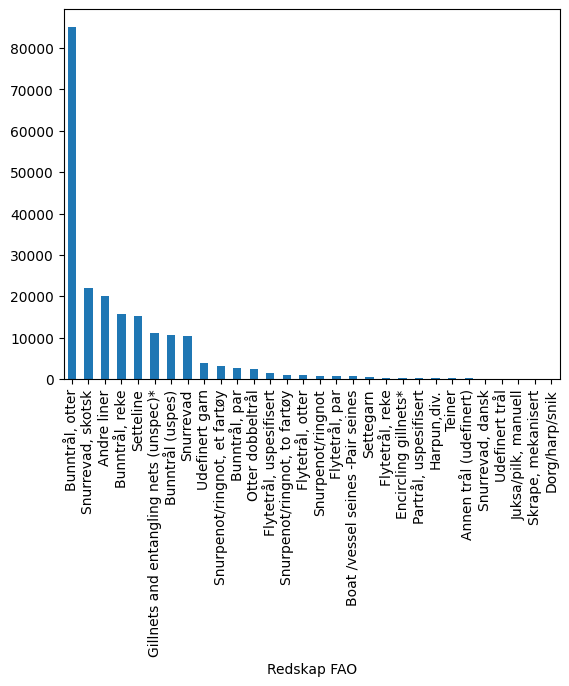

In [3]:
# A count of instances of equipment used for every Bycatch. 
count_of_equipment_used_for_only_Bycatch = bycatch.groupby(["Redskap FAO"])["Redskap FAO"].count()
count_of_equipment_used_for_only_Bycatch = count_of_equipment_used_for_only_Bycatch.sort_values(ascending=False)
count_of_equipment_used_for_only_Bycatch.plot(kind="bar")

<Axes: xlabel='Redskap FAO'>

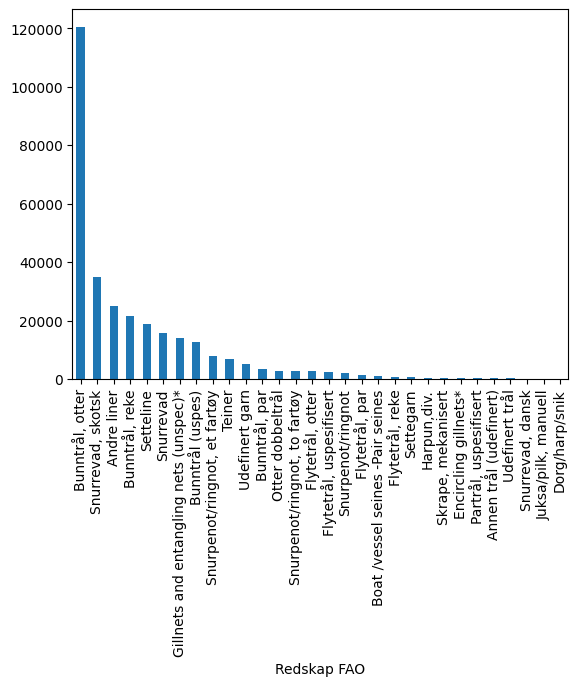

In [4]:
# A count of instances of equipment used for every species. 
count_of_equipment_used_for_original_dataset = dataset.groupby(["Redskap FAO"])["Redskap FAO"].count()
count_of_equipment_used_for_original_dataset = count_of_equipment_used_for_original_dataset.sort_values(ascending=False)
count_of_equipment_used_for_original_dataset.plot(kind="bar")

Although there were a few difference in the distribution, the Bycatch dataset had a more noticeable sections whereas the original dataset had a steady decline. We didn't find there were too much of a difference between the two, and were unsure if it was relevant. So we tried another approach, we checked the correlation between the most common Bycatch species and their equipment. 

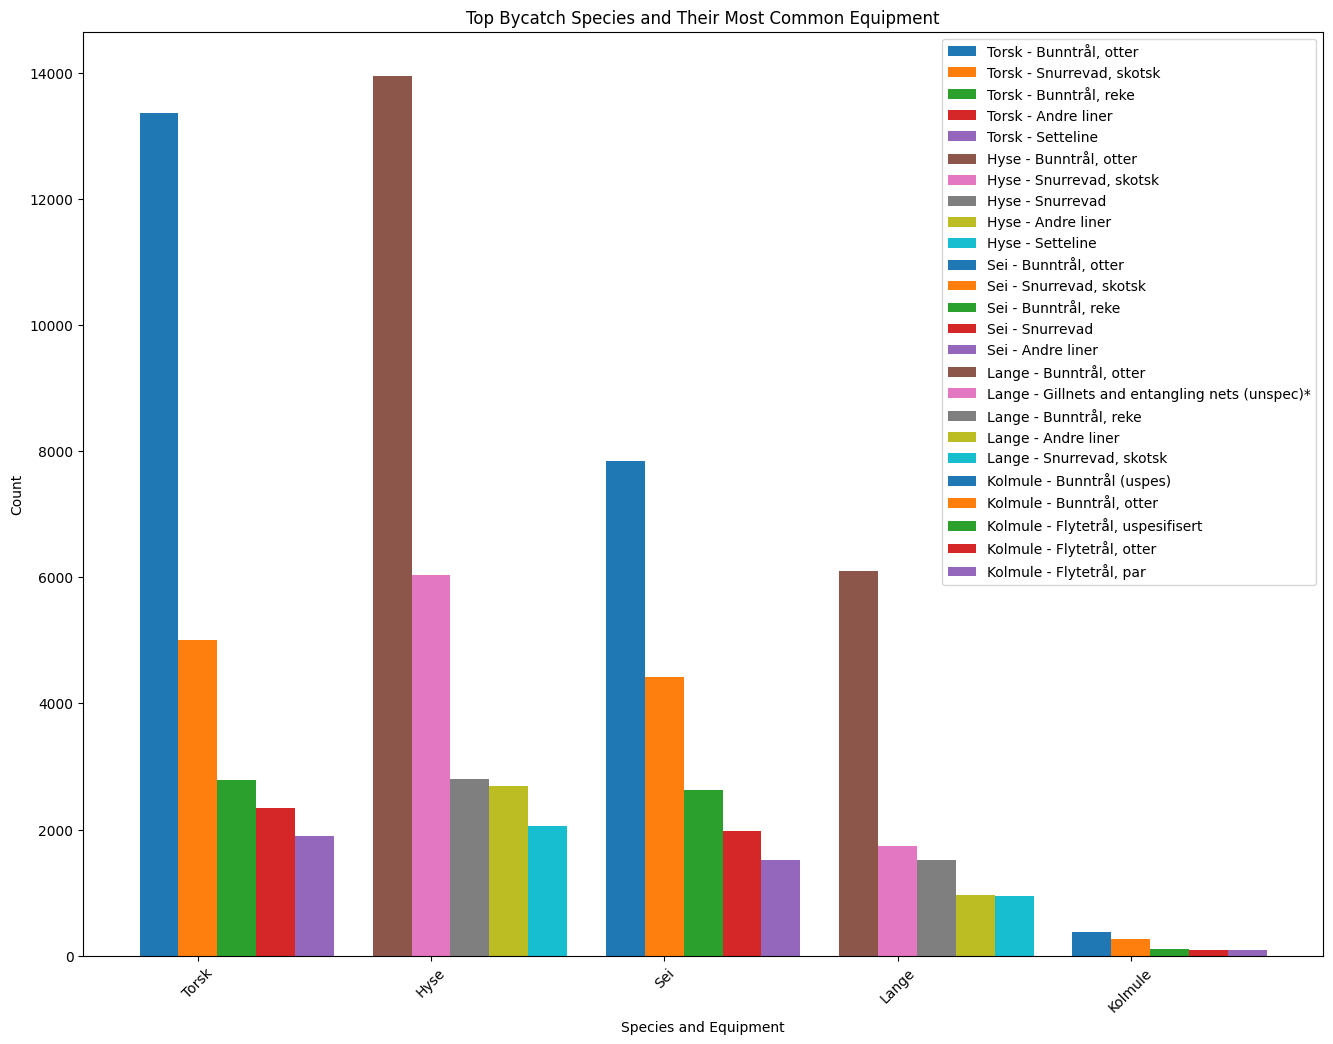

In [5]:
# Finding the most common bycatch, defined by Bycatch species with highest roundweight. 
count_of_Bycatches_for_every_main_species = bycatch.groupby(["Art FAO"])["Rundvekt"].sum()

# Top 5 species 
top_5_common_bycatch = (count_of_Bycatches_for_every_main_species.sort_values(ascending=False))[:5]
top_5_common_bycatch = list(top_5_common_bycatch.index)

fig, ax = plt.subplots(figsize=(16, 12)) 

positions = np.arange(len(top_5_common_bycatch))*3  
width = 0.5

# Finding the most common equipment used for catching each of these species
for i, species in enumerate(top_5_common_bycatch):
    species_only_dataset = bycatch[bycatch["Art FAO"] == species]
    count_of_equipment_used = species_only_dataset.groupby("Redskap FAO")["Redskap FAO"].count()
    top_equipment_for_species = count_of_equipment_used.sort_values(ascending=False).head(5) 
    
    for j, equipment in enumerate(top_equipment_for_species.index):
        ax.bar(positions[i] + j*width, top_equipment_for_species[equipment], width, label=f'{species} - {equipment}')

ax.set_xlabel('Species and Equipment')
ax.set_ylabel('Count')
ax.set_title('Top Bycatch Species and Their Most Common Equipment')

ax.set_xticks(positions + width)
ax.set_xticklabels(top_5_common_bycatch)

plt.legend()
plt.xticks(rotation=45)
plt.show()

Here we see that the distribution of most common equipment used for each species varies a lot, although the top equipments for the species are the same, the rest of the equipments varies. 

#### Gross weight of catch 

This one is relevant because of the way main species is calculated; "Main species caught, reported using the FAO species code. Main species is chosen using highest estimated weight in round kilograms." (datadokumentasjon-ers-rapport-varnivaa-5-140121, p.11) This means that the main species caught on average will be higher than if it were a Bycatch.  


#### Boat information

We chose to use Length group because the data in this feature is already categorized which makes it easier to process and use. We believe that the boat size is relevant when we use it together with equipments as we believe bigger boats use trawl equipments more often. We checked the distribution of equipments for every boat size.

In [6]:
every_lengthgroup = ["28 m og over", "21-27,99 m", "15-20,99 m"]

for length_group in every_lengthgroup:
        lengdegruppe_dataset = dataset[dataset["Lengdegruppe"] == length_group]
        lengdegruppe_equipmentcount = lengdegruppe_dataset.groupby([lengdegruppe_dataset["Redskap FAO"]])["Redskap FAO"].count()
        lengdegruppe_equipmentcount.sort_values(ascending=False, inplace=True)
        print(f"Top 3 common equipment for boats in category: {length_group}\n{lengdegruppe_equipmentcount.head(3)}\n")

Top 3 common equipment for boats in category: 28 m og over
Redskap FAO
Bunntrål, otter      102895
Andre liner           24054
Snurrevad, skotsk     17463
Name: Redskap FAO, dtype: int64

Top 3 common equipment for boats in category: 21-27,99 m
Redskap FAO
Bunntrål, otter      13202
Snurrevad, skotsk    11134
Bunntrål, reke       10051
Name: Redskap FAO, dtype: int64

Top 3 common equipment for boats in category: 15-20,99 m
Redskap FAO
Setteline            7639
Snurrevad, skotsk    6428
Bunntrål, reke       5689
Name: Redskap FAO, dtype: int64



We see that the distribution of equipments used in bigger boats is much more skewed towards trawls than the distribution in smaller boat. Therefore we believe that bigger boats are more likely to result in Bycatch. 

#### Location of trip

To check if the area is relevant we chose to look at a Bycatch and main species dataset for torsk (Because it is the most common species). We compared the areas where they were caught as a Bycatch and where they were caught as the main species.

In [7]:
torsk_only = dataset[dataset['Art FAO'] == "Torsk"]
torsk_only_Bycatch = torsk_only[torsk_only['Hovedart FAO'] != "Torsk"]
torsk_only_main = torsk_only[torsk_only['Hovedart FAO'] == "Torsk"]

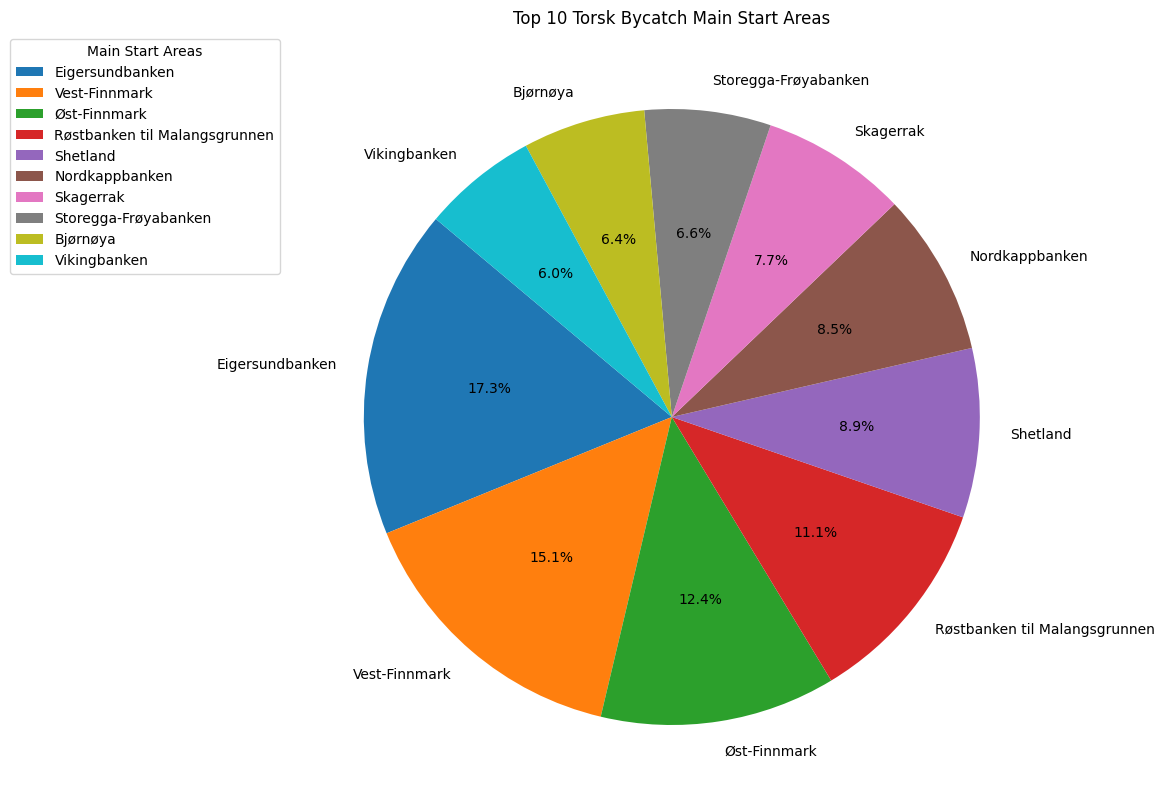

In [8]:

# Count the occurrences of each unique value in 'Hovedområde start', sort, and select top 10
top_10_areas_bycatch_start = torsk_only_Bycatch['Hovedområde start'].value_counts().head(10)

# Plot the top 10 areas
top_10_areas_bycatch_start.plot(kind='pie', figsize=(12, 10), fontsize=10, autopct='%1.1f%%', startangle=140)

plt.title('Top 10 Torsk Bycatch Main Start Areas', fontsize=12)
plt.ylabel('')
plt.legend(title='Main Start Areas', loc='upper right', bbox_to_anchor=(0, 1))
plt.show()


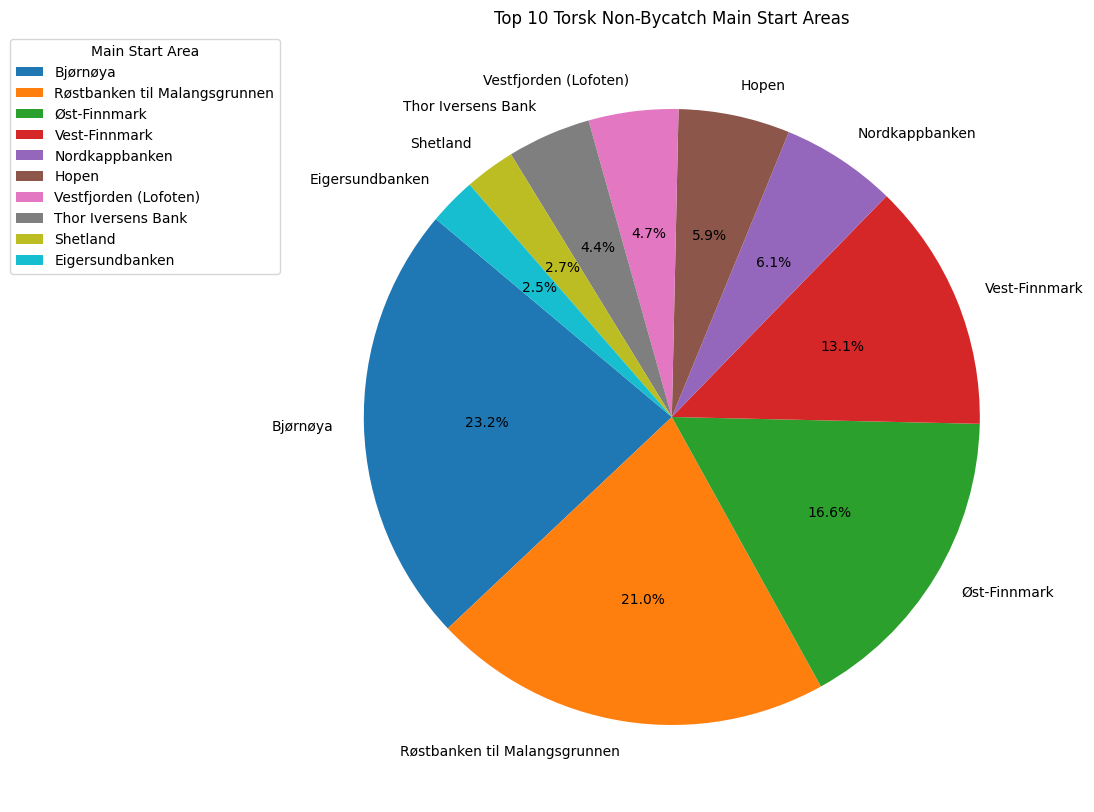

In [9]:

# Count the occurrences of each unique value in 'Hovedområde start', sort, and select top 10
top_10_areas = torsk_only_main['Hovedområde start'].value_counts().head(10)

# Plot the top 10 areas
top_10_areas.plot(kind='pie', figsize=(12, 10), fontsize=10, autopct='%1.1f%%', startangle=140)

plt.title('Top 10 Torsk Non-Bycatch Main Start Areas', fontsize=12)
plt.ylabel('')
plt.legend(title='Main Start Area', loc='upper right', bbox_to_anchor=(0, 1))
plt.show()

There is interestingly a big difference where the fish is caught when we compare Bycatch with main species. 

#### Drag distance

To check if drag distance is relevant when predicting Bycatch we just took a quick look and compared values. 


In [10]:
print("Duration for original dataset:\n", dataset["Trekkavstand"].describe())
print("\n")
print("Duration for bycatch:\n",bycatch["Trekkavstand"].describe())

Duration for original dataset:
 count     305410.000000
mean       15663.968262
std        90330.847329
min            0.000000
25%         2533.000000
50%         7598.000000
75%        22599.000000
max     15888632.000000
Name: Trekkavstand, dtype: float64


Duration for bycatch:
 count     210114.000000
mean       16815.527666
std        87925.570696
min            0.000000
25%         2790.000000
50%         9063.000000
75%        25190.000000
max     15888632.000000
Name: Trekkavstand, dtype: float64


Doesn't look like there is anything special here, maybe we can check drag distance for torsk when a specific equipment is used? We used the most common equipment for catching torsk: Bunntrål 

In [11]:
torsk_only_dragdistance = dataset[dataset["Art FAO"] == "Torsk"]
# Removing an outlier so its easier to read the graph
torsk_only_dragdistance = torsk_only_dragdistance[torsk_only_dragdistance["Trekkavstand"] < 200000]

torsk_as_Bycatch_dragdistance = torsk_only_dragdistance[torsk_only_dragdistance["Hovedart FAO"] != "Torsk"]
torsk_as_Bycatch_dragdistance = torsk_as_Bycatch_dragdistance[torsk_as_Bycatch_dragdistance["Redskap FAO"] == "Bunntrål, otter"]


torsk_as_main_dragdistance = torsk_only_dragdistance[torsk_only_dragdistance["Hovedart FAO"] == "Torsk"]
torsk_as_main_dragdistance = torsk_as_main_dragdistance[torsk_as_main_dragdistance["Redskap FAO"] == "Bunntrål, otter"]

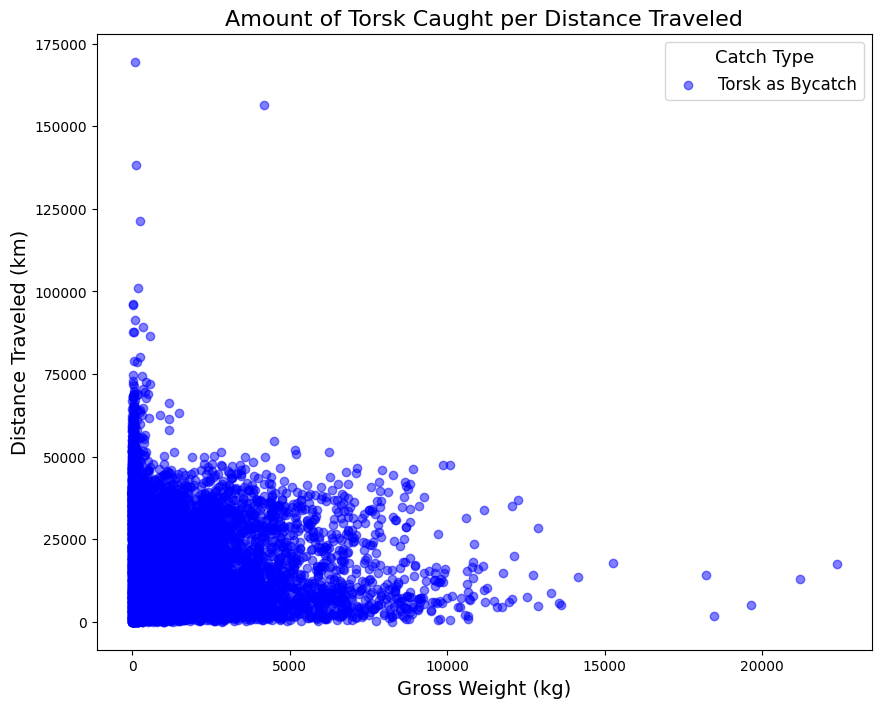

In [12]:
plt.figure(figsize=(10, 8))

# Scatter plot for bycatch
plt.scatter(torsk_as_Bycatch_dragdistance["Rundvekt"], torsk_as_Bycatch_dragdistance["Trekkavstand"], color='blue', alpha=0.5, label='Torsk as Bycatch')

# Adding labels and title
plt.xlabel("Gross Weight (kg)", fontsize=14)
plt.ylabel("Distance Traveled (km)", fontsize=14)
plt.title("Amount of Torsk Caught per Distance Traveled", fontsize=16)

# Adding a legend to distinguish between the two datasets
plt.legend(title="Catch Type", title_fontsize='13', fontsize='12')

# Show the plot
plt.show()

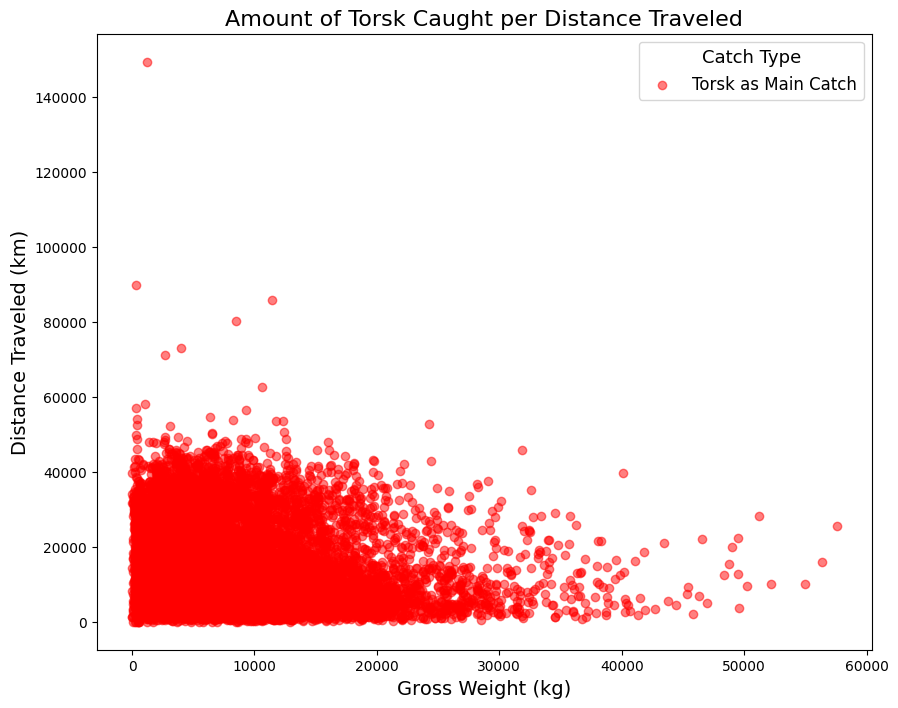

In [13]:
plt.figure(figsize=(10, 8))

# Scatter plot for main catch
plt.scatter(torsk_as_main_dragdistance["Rundvekt"], torsk_as_main_dragdistance["Trekkavstand"], color='red', alpha=0.5, label='Torsk as Main Catch')

# Adding labels and title
plt.xlabel("Gross Weight (kg)", fontsize=14)
plt.ylabel("Distance Traveled (km)", fontsize=14)
plt.title("Amount of Torsk Caught per Distance Traveled", fontsize=16)

# Adding a legend to distinguish between the two datasets
plt.legend(title="Catch Type", title_fontsize='13', fontsize='12')

# Show the plot
plt.show()

In [14]:
# amount of entries from 40 000 to 75 000 in Bycatch
filtered_dragdistance = torsk_as_Bycatch_dragdistance[(torsk_as_Bycatch_dragdistance["Trekkavstand"] > 40000) & (torsk_as_Bycatch_dragdistance["Trekkavstand"] < 75000)]

total_instances = filtered_dragdistance.shape[0]

print(total_instances)

815


Here we see that drag distance makes very little difference, most of the dots in the scatterplot is concentrated around 50-60k. while there are a bit fewer dots in the main species graph around 60k it is only 800 entries.

#### Duration

To check if duration is relevant when predicting Bycatch we just took a quick look and compared values. 

In [15]:
print("Duration for original dataset:\n", dataset["Varighet"].describe())
print("\n")
print("Duration for bycatch:\n", bycatch["Varighet"].describe())

Duration for original dataset:
 count   305434.000000
mean       537.095526
std       2201.624688
min          0.000000
25%        123.000000
50%        296.000000
75%        494.000000
max     125534.000000
Name: Varighet, dtype: float64


Duration for bycatch:
 count   210128.000000
mean       414.088165
std        588.217837
min          0.000000
25%        138.000000
50%        306.000000
75%        547.000000
max     120906.000000
Name: Varighet, dtype: float64


As we can see the 25, 50 and 75 percentile are more or less the same, we believe this doesn't really help us predict Bycatch anyways.

#### Time

To see the relevance of time for our ml model, we can compare the start times of each fishing trip for torsk where the equipment used is the same.

In [16]:
torsk_only_Bycatch_bunntrål = torsk_only_Bycatch[torsk_only_Bycatch["Redskap FAO"] == "Bunntrål, otter"]
torsk_only_main_bunntrål = torsk_only_main[torsk_only_main["Redskap FAO"] == "Bunntrål, otter"]

# Convert columns to datetime format to extract the hour
torsk_only_Bycatch_bunntrål['Startklokkeslett'] = pd.to_datetime(torsk_only_Bycatch_bunntrål['Startklokkeslett'], format='%H:%M')
torsk_only_main_bunntrål['Startklokkeslett'] = pd.to_datetime(torsk_only_main_bunntrål['Startklokkeslett'], format='%H:%M')

# Extract the hour from the start time in both main and Bycatch dataframe
torsk_only_Bycatch_bunntrål['Startklokkeslett_time'] = torsk_only_Bycatch_bunntrål['Startklokkeslett'].dt.hour
torsk_only_main_bunntrål['Startklokkeslett_time'] = torsk_only_main_bunntrål['Startklokkeslett'].dt.hour

# counting hours
hourly_distribution_start = torsk_only_Bycatch_bunntrål['Startklokkeslett_time'].value_counts().sort_index()
hourly_distribution_start2 = torsk_only_main_bunntrål['Startklokkeslett_time'].value_counts().sort_index()

We chose to use a pie-chart because it visualizes the data better when we want to see percentage. 

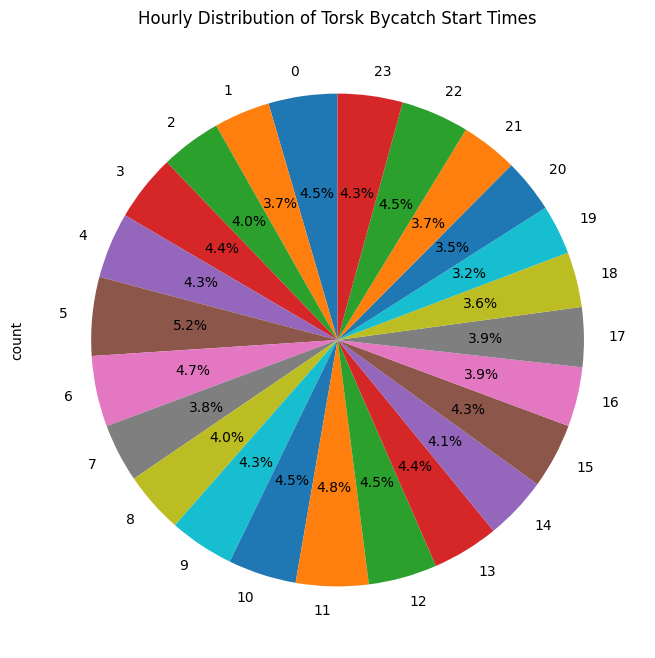

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
hourly_distribution_start.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Hourly Distribution of Torsk Bycatch Start Times')

plt.show()

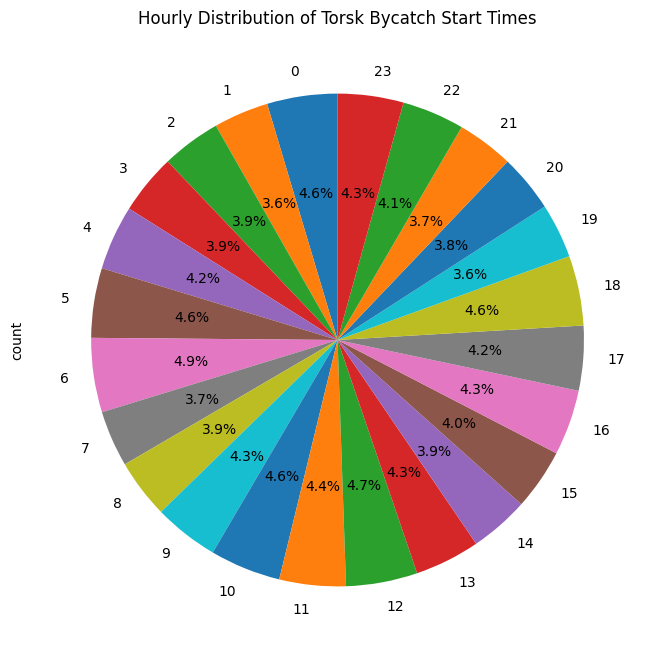

In [18]:
fig, ax = plt.subplots(figsize=(10, 8))
hourly_distribution_start2.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Hourly Distribution of Torsk Bycatch Start Times')

plt.show()

As we can see the start times for Bycatch and main species are basically the same, this makes us believe that it doesn't really matter when the fishing is done as it doesn't impact the statistics for Bycatch. 

### Analyzation
The primary objective of this analysis is to explore findings related to outliers within each chosen features of our dataset. By examining these outliers, we aim to understand their impact on the dataset and determine appropriate strategies for handling them. This process involves identifying outliers, assessing their significance, and deciding on actions such as keeping, modifying, or removing these outliers.
#### Hovedart FAO
Considering that "Hovedart FAO" will be the feature we use to identify if it is a Bycatch the only thing we have to consider are NaN values. 

In [19]:
print(dataset["Hovedart FAO"].isna().sum())
print(dataset["Art FAO"].isna().sum())

# Drop all rows where Hovedart FAO and Art FAO is NaN
dataset = dataset.dropna(subset=["Hovedart FAO", "Art FAO"])

print(dataset["Hovedart FAO"].isna().sum())
print(dataset["Art FAO"].isna().sum())

4978
4982
0
0


Considering that this feature will be a vital part of our ml model we will be dropping all NaN values in this feature, and also considering there are only 5000 entries which is missing the species it shouldn't impact our model that much.

#### Lengdegruppe
Considering this feature is already categorized outliers aren't an issue here, we believe its only relevant to look at NaN values.


In [20]:
print(dataset["Lengdegruppe"].isna().sum())

lengdegruppe_is_NaN = dataset[(dataset["Lengdegruppe"].isna())]

pd.DataFrame(lengdegruppe_is_NaN.head(10))

683


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
347,1497547,02.01.2018 13:34,02.01.2018,13:34,02.01.2018 08:50,02.01.2018,08:50,"63,115","7,604",7.000000,Storegga-Frøyabanken,7.000000,-201,02.01.2018 13:21,02.01.2018,13:21,271,2018,"63,113","7,599",7.000000,Storegga-Frøyabanken,7.000000,-162,337.000000,DRB,"Skrape, mekanisert",80.000000,Annet,LAH,Stortare,2813.000000,LAH,Stortare,2813.000000,Stortare,901.000000,Brunalger,125000.000000,NaN,NaN,NaN,NaN,NaN,"15,5"
939,1498109,03.01.2018 14:07,03.01.2018,14:07,03.01.2018 07:34,03.01.2018,07:34,"62,991","7,091",NaN,NaN,NaN,-43,03.01.2018 14:02,03.01.2018,14:02,388,2018,"62,993","7,1",NaN,NaN,NaN,-25,508.000000,DRB,"Skrape, mekanisert",80.000000,Annet,LAH,Stortare,2813.000000,LAH,Stortare,2813.000000,Stortare,901.000000,Brunalger,128000.000000,NaN,NaN,NaN,NaN,NaN,"15,5"
1486,1498570,04.01.2018 12:21,04.01.2018,12:21,04.01.2018 07:50,04.01.2018,07:50,"64,253","10,2",6.000000,Helgelandsbanken,38.000000,-40,04.01.2018 12:20,04.01.2018,12:20,270,2018,"64,254","10,206",6.000000,Helgelandsbanken,38.000000,-62,312.000000,DRB,"Skrape, mekanisert",80.000000,Annet,LAH,Stortare,2813.000000,LAH,Stortare,2813.000000,Stortare,901.000000,Brunalger,93000.000000,NaN,NaN,NaN,NaN,NaN,"16,24"
1512,1498659,04.01.2018 15:00,04.01.2018,15:00,04.01.2018 08:59,04.01.2018,08:59,"63,116","7,585",7.000000,Storegga-Frøyabanken,7.000000,-157,04.01.2018 14:39,04.01.2018,14:39,340,2018,"63,115","7,601",7.000000,Storegga-Frøyabanken,7.000000,-201,815.000000,DRB,"Skrape, mekanisert",80.000000,Annet,LAH,Stortare,2813.000000,LAH,Stortare,2813.000000,Stortare,901.000000,Brunalger,118000.000000,NaN,NaN,NaN,NaN,NaN,"15,5"
1608,1498830,04.01.2018 20:23,04.01.2018,20:23,04.01.2018 14:51,04.01.2018,14:51,"64,25","10,21",6.000000,Helgelandsbanken,38.000000,-6,04.01.2018 20:22,04.01.2018,20:22,331,2018,"64,254","10,196",6.000000,Helgelandsbanken,38.000000,-40,812.000000,DRB,"Skrape, mekanisert",80.000000,Annet,LAH,Stortare,2813.000000,LAH,Stortare,2813.000000,Stortare,901.000000,Brunalger,80000.000000,NaN,NaN,NaN,NaN,NaN,"16,24"
2260,1499177,05.01.2018 11:33,05.01.2018,11:33,05.01.2018 07:47,05.01.2018,07:47,"64,255","10,15",6.000000,Helgelandsbanken,38.000000,-39,05.01.2018 11:32,05.01.2018,11:32,225,2018,"64,252","10,147",6.000000,Helgelandsbanken,38.000000,-39,365.000000,DRB,"Skrape, mekanisert",80.000000,Annet,LAH,Stortare,2813.000000,LAH,Stortare,2813.000000,Stortare,901.000000,Brunalger,82000.000000,NaN,NaN,NaN,NaN,NaN,"16,24"
2363,1499375,05.01.2018 18:28,05.01.2018,18:28,05.01.2018 13:45,05.01.2018,13:45,"64,25","10,183",6.000000,Helgelandsbanken,38.000000,-22,05.01.2018 18:27,05.01.2018,18:27,282,2018,"64,255","10,156",6.000000,Helgelandsbanken,38.000000,-33,1423.000000,DRB,"Skrape, mekanisert",80.000000,Annet,LAH,Stortare,2813.000000,LAH,Stortare,2813.000000,Stortare,901.000000,Brunalger,90000.000000,NaN,NaN,NaN,NaN,NaN,"16,24"
2785,1499610,06.01.2018 01:25,06.01.2018,01:25,05.01.2018 21:27,05.01.2018,21:27,"64,252","10,146",6.000000,Helgelandsbanken,38.000000,-39,06.01.2018 01:24,06.01.2018,01:24,237,2018,"64,251","10,188",6.000000,Helgelandsbanken,38.000000,-50,2040.000000,DRB,"Skrape, mekanisert",80.000000,Annet,LAH,Stortare,2813.000000,LAH,Stortare,2813.000000,Stortare,901.000000,Brunalger,55000.000000,NaN,NaN,NaN,NaN,NaN,"16,24"
5791,1502169,10

At first glance we were planning on dropping these values, however when we actually look at the values here we can see that most catches without a specified boat length is when Stortare is caught. 

In [21]:
art_fao_counts_lengdegruppe = lengdegruppe_is_NaN['Art FAO'].value_counts()

# Printing the counts for each unique value in 'Art FAO'
print(art_fao_counts_lengdegruppe)

Art FAO
Stortare    683
Name: count, dtype: int64


Looks like rather than dropping NaN values we will be converting them into a special group, this is because all NaN values are catching Stortare. 

In [22]:
dataset['Lengdegruppe'] = dataset['Lengdegruppe'].fillna('Stortare båter')

#### Redskap FAO
Looking at NaN values

In [23]:
print(dataset["Redskap FAO"].isna().sum())
redskap_FAO_is_NaN = dataset[dataset["Redskap FAO"].isna()]
pd.DataFrame(redskap_FAO_is_NaN).head(10)


187


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
13304,1507836,19.01.2018 17:31,19.01.2018,17:31,19.01.2018 05:40,19.01.2018,05:40,"71,092","23,234",4.000000,Vest-Finnmark,24.000000,-282,19.01.2018 06:58,19.01.2018,06:58,78,2018,"71,094","23,274",4.000000,Vest-Finnmark,24.000000,-272,1464.000000,SND,NaN,NaN,NaN,COD,Torsk,1022.000000,COD,Torsk,1022.000000,Torsk,201.000000,Torsk,1650.000000,4.000000,"21-27,99 m",NaN,99.000000,"6,74","24,15"
13305,1507836,19.01.2018 17:31,19.01.2018,17:31,19.01.2018 05:40,19.01.2018,05:40,"71,092","23,234",4.000000,Vest-Finnmark,24.000000,-282,19.01.2018 06:58,19.01.2018,06:58,78,2018,"71,094","23,274",4.000000,Vest-Finnmark,24.000000,-272,1464.000000,SND,NaN,NaN,NaN,COD,Torsk,1022.000000,POK,Sei,1032.000000,Sei,203.000000,Sei,420.000000,4.000000,"21-27,99 m",NaN,99.000000,"6,74","24,15"
13306,1507836,19.01.2018 17:31,19.01.2018,17:31,19.01.2018 05:40,19.01.2018,05:40,"71,092","23,234",4.000000,Vest-Finnmark,24.000000,-282,19.01.2018 06:58,19.01.2018,06:58,78,2018,"71,094","23,274",4.000000,Vest-Finnmark,24.000000,-272,1464.000000,SND,NaN,NaN,NaN,COD,Torsk,1022.000000,HAD,Hyse,1027.000000,Hyse,202.000000,Hyse,5.000000,4.000000,"21-27,99 m",NaN,99.000000,"6,74","24,15"
13307,1507836,19.01.2018 17:31,19.01.2018,17:31,19.01.2018 09:08,19.01.2018,09:08,"71,088","23,306",4.000000,Vest-Finnmark,24.000000,-242,19.01.2018 09:57,19.01.2018,09:57,49,2018,"71,086","23,295",4.000000,Vest-Finnmark,24.000000,-245,456.000000,SND,NaN,NaN,NaN,COD,Torsk,1022.000000,COD,Torsk,1022.000000,Torsk,201.000000,Torsk,6300.000000,4.000000,"21-27,99 m",NaN,99.000000,"6,74","24,15"
13308,1507836,19.01.2018 17:31,19.01.2018,17:31,19.01.2018 09:08,19.01.2018,09:08,"71,088","23,306",4.000000,Vest-Finnmark,24.000000,-242,19.01.2018 09:57,19.01.2018,09:57,49,2018,"71,086","23,295",4.000000,Vest-Finnmark,24.000000,-245,456.000000,SND,NaN,NaN,NaN,COD,Torsk,1022.000000,POK,Sei,1032.000000,Sei,203.000000,Sei,50.000000,4.000000,"21-27,99 m",NaN,99.000000,"6,74","24,15"
13309,1507836,19.01.2018 17:31,19.01.2018,17:31,19.01.2018 11:48,19.01.2018,11:48,"71,093","23,336",4.000000,Vest-Finnmark,24.000000,-249,19.01.2018 13:00,19.01.2018,13:00,72,2018,"71,09","23,324",4.000000,Vest-Finnmark,24.000000,-236,548.000000,SND,NaN,NaN,NaN,COD,Torsk,1022.000000,COD,Torsk,1022.000000,Torsk,201.000000,Torsk,6800.000000,4.000000,"21-27,99 m",NaN,99.000000,"6,74","24,15"
13310,1507836,19.01.2018 17:31,19.01.2018,17:31,19.01.2018 11:48,19.01.2018,11:48,"71,093","23,336",4.000000,Vest-Finnmark,24.000000,-249,19.01.2018 13:00,19.01.2018,13:00,72,2018,"71,09","23,324",4.000000,Vest-Finnmark,24.000000,-236,548.000000,SND,NaN,NaN,NaN,COD,Torsk,1022.000000,HAD,Hyse,1027.000000,Hyse,202.000000,Hyse,10.000000,4.000000,"21-27,99 m",NaN,99.000000,"6,74","24,15"
13311,1507836,19.01.2018 17:31,19.01.2018,17:31,19.01.2018 11:48,19.01.2018,11:48,"71,093","23,336",4.000000,Vest-Finnmark,24.000000,-249,19.01.2018 13:00,19.01.2018,13:00,72,2018,"71,09","23,324",4.000000,Vest-Finnmark,24.000000,-236,548.000000,SND,NaN,NaN,NaN,COD,Torsk,1022.000000,POK,Sei,1032.000000,Sei,203.000000,Sei,10.000000,4.000000,"21-27,99 m",NaN,99.000000,"6,74","24,15"
13312,1507836,19.01.2018 17:31,19.01.2018,17:31,19.01.2018 14:29,19.01.2018,14:29,"71,084","23,326",4.000000,Vest-Finnmark,24.000000,-233,19.01.2018 16:35,19.01.2

Considering there are only 200 NaN values the easiest solution will be dropping them, although they have aren't missing any values other than Redskap FAO we feel that the amount of work that would be needed to impute or replace the missing values will be unnoticeable in the ml models accuracy.

In [24]:
dataset = dataset.dropna(subset=["Redskap FAO"])

#### Rundvekt
When looking at outliers we can assume that since different species most likely have a different average gross weight we should be looking for outliers for each individual species. We chose to use box plots to visualize these because they show outliers well.

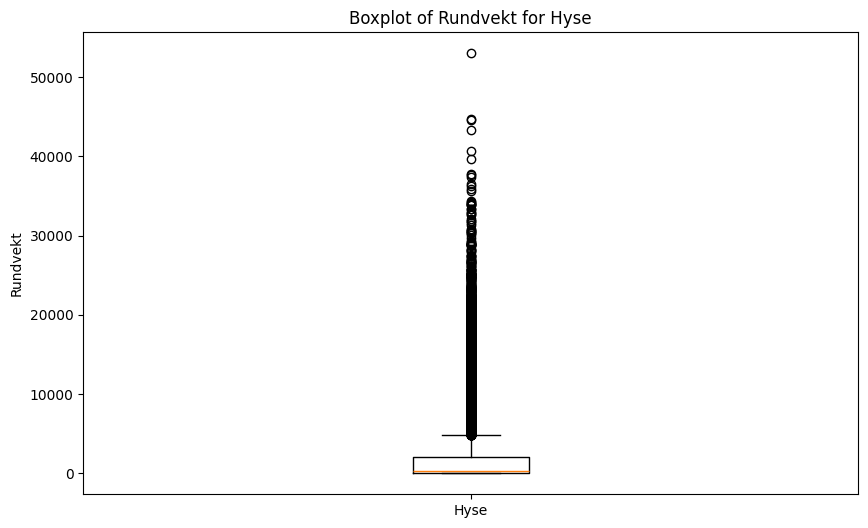

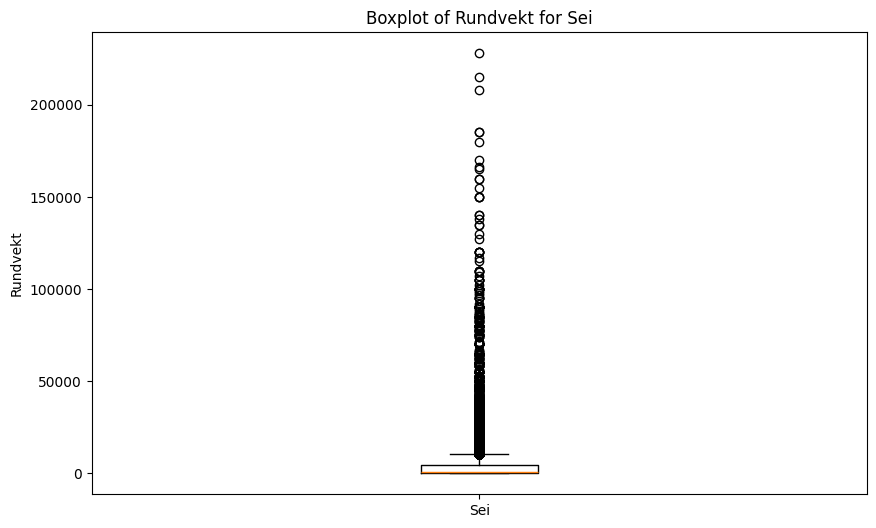

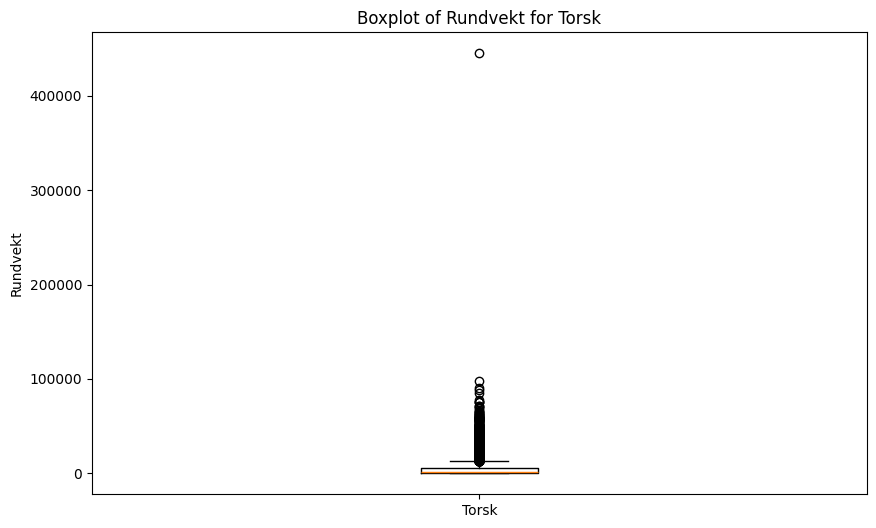

In [25]:
species_grossweight = dataset.groupby("Art FAO")["Rundvekt"].apply(list)

# Define the species of interest
species_of_interest = ["Torsk", "Hyse", "Sei"]

# Filter the aggregated data to include only the species of interest
filtered_species_grossweight = {species: weights for species, weights in species_grossweight.items() if species in species_of_interest}

# Iterate over the filtered Series using .items() for species and their corresponding gross weights
for species, grossweights in filtered_species_grossweight.items():
    plt.figure(figsize=(10, 6))  # Create a new figure for each species
    
    # Create a boxplot for the species
    plt.boxplot(grossweights)
    plt.title(f'Boxplot of Rundvekt for {species}')
    plt.ylabel('Rundvekt')
    plt.xticks([1], [species])  # Set the x-tick to the name of the current species
    
    plt.show()  # Show the plot for the current species

Seems like there are many outliers for each species, we believe it will be difficult to outright remove outliers since there are 122 different species and there are probably some species with few outliers while others have a lot. According to "Introduction to Machine Learning with Python: A Guide for Data Scientists" by Andreas C. Müller and Sarah Guido (p.133), employing a RobustScaler offers a strategic solution to this issue. The RobustScaler effectively transforms the data by ignoring points that significantly deviate from the rest, making it particularly suitable for our dataset where outliers are prevalent but their outright removal is impractical."

Checking for NaN values in Gross weight. 

In [26]:
print(dataset["Rundvekt"].isna().sum())
print("#: ", dataset.isna().sum())

0
#:  Melding ID                       0
Meldingstidspunkt                0
Meldingsdato                     0
Meldingsklokkeslett              0
Starttidspunkt                   0
Startdato                        0
Startklokkeslett                 0
Startposisjon bredde             0
Startposisjon lengde             0
Hovedområde start (kode)      1814
Hovedområde start             3788
Lokasjon start (kode)         1814
Havdybde start                   0
Stopptidspunkt                   0
Stoppdato                        0
Stoppklokkeslett                 0
Varighet                         0
Fangstår                         0
Stopposisjon bredde              0
Stopposisjon lengde              0
Hovedområde stopp (kode)      1782
Hovedområde stopp             3788
Lokasjon stopp (kode)         1782
Havdybde stopp                   0
Trekkavstand                    19
Redskap FAO (kode)               0
Redskap FAO                      0
Redskap FDIR (kode)              0
Redskap FDIR  

## Supervised learning
In "Introduction to Machine Learning with Python", the book discusses seven different machine learning models: k-Nearest Neighbors (k-NN), linear models, Naive Bayes, decision trees, ensembles of decision trees and neural networks. 

### Picking the Machine learning models 
Considering we have 6 features, where 5 of them are categorical and 1 is continuous data, we will have to keep this distribution in mind when picking out models. Since we will be trying to classify Bycatch, we will not be looking at regression models. 

#### k-NN
The k-Nearest Neighbors (k-NN) algorithm makes predictions based on the closest data points in the training dataset. Considering that we only have 6 features, this model seems promising as it should not be too difficult to find data points in the training set that closely match those in the test set.

considering most of our data is categorical we are unsure how easy it will be to scale them, we are working with 122 different species in one feature.

#### Linear models
Linear models make a prediction using a linear function of the input features. Considering we are working with a multi-class classification problem, a logistic regression model seems like a viable option. Considering we are working with over 100 species and many more different features, the L1 regularization seems pretty compelling to use since we are unsure how many of the features are actually relevant. 

#### Naive Bayes
We can rule out Bernoulli naive bayes model because its impossible for us to convert our data to binary. We can also rule out gaussian since it's hard for us to convert our data to real numbers. 

MultinomialNB we might be able to express our data as counts (e.g., the number of times a specific species is observed, the count of different equipment used, etc.), it can then model the probability of each class based on the frequency of these occurrences. This doesn't seem that hard but is a lot of work and seems interesting. 

CategoricalNB, seems like the easiest and most straight forward model for us to pick. We won't need to pre-process our data as much.

#### Decision trees
"Decision trees are widely used models for classification and regression tasks. Essentially, they learn a hierarchy of if/else questions, leading to a decision."-"Introduction to Machine Learning with Python: A Guide for Data Scientists" by Andreas C. Müller and Sarah Guido (p.70)

Considering these basic trees tend to overfit and don't do well with many features, we will not be considering them.

#### Ensembles of decision trees
Ensembles combines multiple machine learning models, this is to better generalize the data even if each model overfits. this model generates many different trees (which will all overfit), it then uses the average or voting to decide on a value. 

Considering we have over 100 features and 300 000 entries, the most logical choice would be to go with gradient boosting. Since gradient boosting prunes to make smaller trees. 


#### Neural networks
Is a class of machine learning algorithms that works well with large datasets. They consist of layers of interconnected nodes or neurons, where each connection represents a weighted pathway, and nodes process inputs using activation functions to produce outputs. 

### Our choices 
We will be using the following models for supervised learning; Logistic regression, gradient boosting, neural network. Because of the aforementioned reasons we believe they are the most logical considering we are working with a classification problem and a lot of different features

####

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


In [28]:
dataset.dropna(inplace=True)
dataset["Is_Bycatch"] = (dataset["Hovedart FAO"] != dataset["Art FAO"])

the_colums_to_keep = ["Is_Bycatch", "Hovedart FAO", "Art FAO", "Redskap FAO", "Rundvekt", "Lengdegruppe", "Hovedområde start", "Trekkavstand" ] # This is all the different differnt labels we are using but we also shoud clasefy why we are using ths spesefic and not othere that are of the same type.
data_selected = dataset[the_colums_to_keep]
dataset = data_selected                         

column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(), ["Is_Bycatch", "Hovedart FAO", "Art FAO", "Redskap FAO","Lengdegruppe", "Hovedområde start"]),  
        ("scaler", MinMaxScaler(), [ "Rundvekt", "Trekkavstand"])
    ],
    remainder='passthrough'  
)

dataset = column_transformer.fit_transform(dataset)

print(dataset)

dataset = pd.DataFrame.sparse.from_spmatrix(dataset)

X = dataset.drop(columns=[0, 1])        
y = dataset[0]                       
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4) 

print(X_train.head(5))

  (0, 0)	1.0
  (0, 15)	1.0
  (0, 47)	1.0
  (0, 52)	1.0
  (0, 63)	1.0
  (0, 91)	1.0
  (0, 93)	0.0012390488110137672
  (0, 94)	0.030189310115750618
  (1, 0)	1.0
  (1, 15)	1.0
  (1, 47)	1.0
  (1, 52)	1.0
  (1, 63)	1.0
  (1, 64)	1.0
  (1, 93)	0.0030976220275344183
  (1, 94)	0.12410965292412197
  (2, 0)	1.0
  (2, 15)	1.0
  (2, 47)	1.0
  (2, 52)	1.0
  (2, 63)	1.0
  (2, 81)	1.0
  (2, 93)	0.004336670838548186
  (2, 94)	0.017303199750108886
  (3, 1)	1.0
  :	:
  (5967, 94)	0.013849598986357178
  (5968, 1)	1.0
  (5968, 15)	1.0
  (5968, 25)	1.0
  (5968, 56)	1.0
  (5968, 63)	1.0
  (5968, 68)	1.0
  (5968, 93)	0.0005469336670838548
  (5968, 94)	0.013849598986357178
  (5969, 1)	1.0
  (5969, 15)	1.0
  (5969, 24)	1.0
  (5969, 56)	1.0
  (5969, 63)	1.0
  (5969, 68)	1.0
  (5969, 93)	0.00021902377972465582
  (5969, 94)	0.013849598986357178
  (5970, 1)	1.0
  (5970, 15)	1.0
  (5970, 48)	1.0
  (5970, 56)	1.0
  (5970, 63)	1.0
  (5970, 68)	1.0
  (5970, 93)	0.00019023779724655821
  (5970, 94)	0.013849598986357178

In [30]:

clf = MLPClassifier(verbose=True, learning_rate_init=0.001, hidden_layer_sizes=(100, 50), max_iter=500, random_state=4)

clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_test_pred, y_train)
print("Training accuracy: ", train_accuracy)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Iteration 1, loss = 0.63066441
Iteration 2, loss = 0.50374948
Iteration 3, loss = 0.42687730
Iteration 4, loss = 0.33648939
Iteration 5, loss = 0.23969519
Iteration 6, loss = 0.14873309
Iteration 7, loss = 0.08272142
Iteration 8, loss = 0.04396941
Iteration 9, loss = 0.02468667
Iteration 10, loss = 0.01515943
Iteration 11, loss = 0.01012748
Iteration 12, loss = 0.00725505
Iteration 13, loss = 0.00536198
Iteration 14, loss = 0.00414210
Iteration 15, loss = 0.00324154
Iteration 16, loss = 0.00261199
Iteration 17, loss = 0.00214705
Iteration 18, loss = 0.00180088
Iteration 19, loss = 0.00152309
Iteration 20, loss = 0.00131271
Iteration 21, loss = 0.00114653
Iteration 22, loss = 0.00100933
Iteration 23, loss = 0.00089797
Iteration 24, loss = 0.00080569
Iteration 25, loss = 0.00073802
Iteration 26, loss = 0.00066692
Iteration 27, loss = 0.00060635
Iteration 28, loss = 0.00055902
Iteration 29, loss = 0.00051668
Iteration 30, loss = 0.00047698
Iteration 31, loss = 0.00044524
Iteration 32, los